In [1]:
import torch
from torch_geometric import datasets
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader 
import matplotlib.pyplot as plt
from tqdm import tqdm

from losses import kl_div_vmf, normal_kl_div, reconstruction_loss, normal_reconstruction_loss
from train_utils import get_edge_probs
from models import VGAE
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = datasets.Planetoid(root='__data/Cora', name='Cora', split='public')

In [4]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False) # because we perform negative sampling at each epoch ourselves

In [6]:
train_data, val_data, test_data = transform(dataset[0])

In [7]:
print('train data', train_data)
print('val data', val_data)
print('test data', test_data)

print(dataset[0].edge_index.shape[1])
print(train_data.pos_edge_label.size(0)*2 + val_data.pos_edge_label.size(0) + val_data.neg_edge_label.size(0) + test_data.pos_edge_label.size(0) + test_data.neg_edge_label.size(0))

train data Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488])
val data Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263])
test data Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[527], pos_edge_label_index=[2, 527], neg_edge_label=[527], neg_edge_label_index=[2, 527])
10556
10556


In [9]:
# train_data['neg_edge_label_index'] = negative_sampling(train_data.pos_edge_label_index)

In [10]:
feature_dim = dataset[0].x.shape[1]
print('input dim', feature_dim)

input dim 1433


## Check model forward pass

In [11]:
val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)
val_edge_label_index.shape

torch.Size([2, 526])

In [12]:
n_vgae = VGAE(input_dim=feature_dim, latent_dim=16, dropout=0.0, latent_distr='normal').to(device)

out_n_vgae, mus_n_vgae, logsigmas2s_n_vgae  = n_vgae(val_data.x.to(device), val_edge_label_index.to(device))
print('out', out_n_vgae.shape)
print('mus', mus_n_vgae.shape)
print('logsigmas2s', logsigmas2s_n_vgae.shape)
labs, edge_probs = get_edge_probs(out_n_vgae, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
print('edge probs', len(edge_probs)==len(labs))

out torch.Size([2708, 2708])
mus torch.Size([2708, 16])
logsigmas2s torch.Size([2708, 16])
edge probs True


In [13]:
s_vgae = VGAE(input_dim=feature_dim, latent_dim=16, dropout=0.0, latent_distr='vMF').to(device)


out_s_vgae, mus_s_vgae, kappas_s_vgae, ws, epss, bs  = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
print('out', out_s_vgae.shape)
print('mus', mus_s_vgae.shape)
print('kappas', kappas_s_vgae.shape)
print('ws', ws.shape)
print('epss', epss.shape)
print('bs', bs.shape)
labs, edge_probs = get_edge_probs(out_n_vgae, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
print('edge probs', len(edge_probs)==len(labs))

out torch.Size([2708, 2708])
mus torch.Size([2708, 16])
kappas torch.Size([2708])
ws torch.Size([2708])
epss torch.Size([2708])
bs torch.Size([2708])
edge probs True


## Train $\mathcal{N}$-VGAE

In [14]:
n_vgae = VGAE(input_dim=feature_dim, latent_dim=16, dropout=0.0, latent_distr='normal').to(device)
num_epochs = 200
lr = 0.01
optimizer = torch.optim.Adam(n_vgae.parameters(), lr=lr)

In [15]:
log_loss = {'train': [] }
log_metrics = {'val_auc' : [],
               'val_ap' : []}
#val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)

for epoch in range(num_epochs):

    # negative sampling 
    train_neg_edge_index = negative_sampling(train_data.edge_index, force_undirected=True)
    #train_data['edge_label_index'] = torch.cat([train_data.pos_edge_label_index, train_neg_edge_index], dim=1)
    
    optimizer.zero_grad()
    output, mus, logsigma2s = n_vgae(train_data.x.to(device), train_data.edge_index.to(device) )
    loss = normal_reconstruction_loss(output, train_data.edge_index, train_neg_edge_index) + .0*normal_kl_div(logsigma2s, mus) 
    
    loss.backward()

    optimizer.step()

    with torch.no_grad():
        #print('neg sampling ?', train_data.edge_label_index[-10:])
        if epoch % 5 == 0:
            #out_val, mus_val, logsigma2s_val = n_vgae(val_data.x.to(device), val_edge_label_index.to(device))
            val_labs, edge_probs_val = get_edge_probs(output, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
            log_metrics['val_auc'].append(roc_auc_score(val_labs, edge_probs_val))
            log_metrics['val_ap'].append(average_precision_score(val_labs, edge_probs_val))
            log_loss['train'].append(loss.item())
        

        if epoch % 10 == 0:
            print('Epoch: {:3d}, VAL AUC: {:.4f}'.format(epoch, log_metrics['val_auc'][-1]))
            print(f'Epoch {epoch:3d}, TRAIN LOSS: {loss.item():.4f}')


Epoch:   0, VAL AUC: 0.5110
Epoch   0, TRAIN LOSS: 30712.0449
Epoch:  10, VAL AUC: 0.7078
Epoch  10, TRAIN LOSS: 11640.8535
Epoch:  20, VAL AUC: 0.8585
Epoch  20, TRAIN LOSS: 8938.9688
Epoch:  30, VAL AUC: 0.8732
Epoch  30, TRAIN LOSS: 8285.2227
Epoch:  40, VAL AUC: 0.8765
Epoch  40, TRAIN LOSS: 7928.5112
Epoch:  50, VAL AUC: 0.8861
Epoch  50, TRAIN LOSS: 7741.3809
Epoch:  60, VAL AUC: 0.8849
Epoch  60, TRAIN LOSS: 7747.2412
Epoch:  70, VAL AUC: 0.8865
Epoch  70, TRAIN LOSS: 7624.2744
Epoch:  80, VAL AUC: 0.8866
Epoch  80, TRAIN LOSS: 7511.6523
Epoch:  90, VAL AUC: 0.8912
Epoch  90, TRAIN LOSS: 7523.8398
Epoch: 100, VAL AUC: 0.8849
Epoch 100, TRAIN LOSS: 7559.3882
Epoch: 110, VAL AUC: 0.9005
Epoch 110, TRAIN LOSS: 7464.2090
Epoch: 120, VAL AUC: 0.8943
Epoch 120, TRAIN LOSS: 7525.4487
Epoch: 130, VAL AUC: 0.8956
Epoch 130, TRAIN LOSS: 7434.8887
Epoch: 140, VAL AUC: 0.8931
Epoch 140, TRAIN LOSS: 7336.9067
Epoch: 150, VAL AUC: 0.8849
Epoch 150, TRAIN LOSS: 7445.2637
Epoch: 160, VAL AUC: 0

### Plot curves

In [16]:
def plot_curves(log_loss):
    fig, ax = plt.subplots()

    ax.plot(log_loss['train'], label='train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Learning curves')

    plt.show()  
    

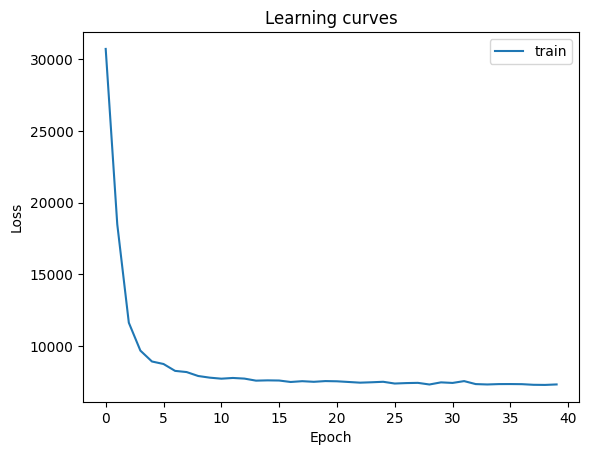

In [17]:
plot_curves(log_loss)

## Train $\mathcal{S}$-VGAE

In [20]:
s_vgae = VGAE(input_dim=feature_dim, latent_dim=16, dropout=0.0, latent_distr='vMF').to(device)
num_epochs = 200
lr = 0.01
optimizer = torch.optim.Adam(s_vgae.parameters(), lr=lr)

In [21]:
log_loss = {'train': [] }
log_metrics = {'val_auc' : [],
               'val_ap' : []}
#val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)

for epoch in range(num_epochs):

    # negative sampling 
    train_neg_edge_index = negative_sampling(train_data.edge_index, force_undirected=True)
    #train_data['edge_label_index'] = torch.cat([train_data.pos_edge_label_index, train_neg_edge_index], dim=1)


    kl = kl_div_vmf.apply
    
    optimizer.zero_grad()
    output, mus, kappas, ws, epss, bs = s_vgae(train_data.x.to(device), train_data.edge_index.to(device) )
    #kappas = torch.exp(logkappas)
    loss = reconstruction_loss(output, train_data.edge_index, train_neg_edge_index, ws, kappas, bs, epss, mus.shape[1]) + kl(kappas, mus) 
    print(loss)
    
    loss.backward()

    optimizer.step()

    with torch.no_grad():
        #print('neg sampling ?', train_data.edge_label_index[-10:])
        #out_val, mus_val, logkappas_val, _, _, _ = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
        log_loss['train'].append(loss.item())
        if epoch % 5 == 0:
            #out_val, mus_val, logkappas_val, ws, epss, bs = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
            val_labs, edge_probs_val = get_edge_probs(output, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
            log_metrics['val_auc'].append(roc_auc_score(val_labs, edge_probs_val))
            log_metrics['val_ap'].append(average_precision_score(val_labs, edge_probs_val))
        

        if epoch % 10 == 0:
            print('Epoch: {:3d}, VAL AUC: {:.4f}'.format(epoch, log_metrics['val_auc'][-1]))
            print(f'Epoch {epoch:3d}, TRAIN LOSS: {loss.item():.4f}')


tensor(14283.6084, grad_fn=<AddBackward0>)
Epoch:   0, VAL AUC: 0.4779
Epoch   0, TRAIN LOSS: 14283.6084
tensor(13866.8848, grad_fn=<AddBackward0>)
tensor(13563.1689, grad_fn=<AddBackward0>)
tensor(13345.0137, grad_fn=<AddBackward0>)
tensor(13187.7422, grad_fn=<AddBackward0>)
tensor(13234.7383, grad_fn=<AddBackward0>)
tensor(13316.9512, grad_fn=<AddBackward0>)
tensor(13249.2773, grad_fn=<AddBackward0>)
tensor(13255.1670, grad_fn=<AddBackward0>)
tensor(13162.8789, grad_fn=<AddBackward0>)
tensor(13269.2256, grad_fn=<AddBackward0>)
Epoch:  10, VAL AUC: 0.5072
Epoch  10, TRAIN LOSS: 13269.2256
tensor(13124.5215, grad_fn=<AddBackward0>)
tensor(13281.2812, grad_fn=<AddBackward0>)
tensor(13137.4043, grad_fn=<AddBackward0>)
tensor(13267.1035, grad_fn=<AddBackward0>)
tensor(13439.5400, grad_fn=<AddBackward0>)
tensor(13267.3926, grad_fn=<AddBackward0>)
tensor(13239.5508, grad_fn=<AddBackward0>)
tensor(13168.9561, grad_fn=<AddBackward0>)
tensor(13196.6914, grad_fn=<AddBackward0>)
tensor(13109.929

KeyboardInterrupt: 

In [73]:
def plot_curves(log_loss):
    fig, ax = plt.subplots()

    ax.plot(log_loss['train'], label='train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Learning curves')

    plt.show()  
    

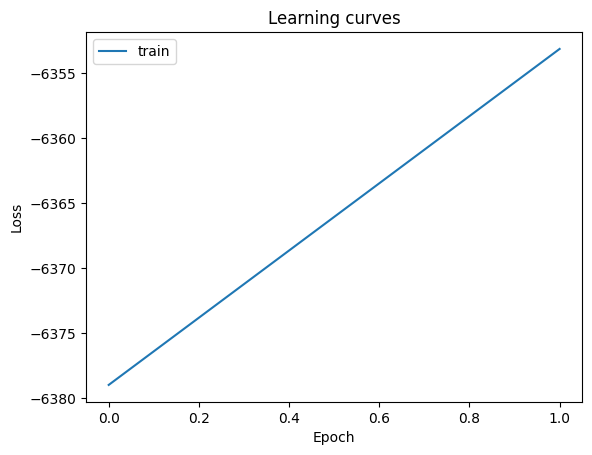

In [74]:
plot_curves(log_loss)

## Grid search 
as done in the article 

In [ ]:
from itertools import product
from pathlib import Path
import pickle

latent_dim = [8, 16, 32]
learning_rates = [.01, .005, .001]

results = Path('results')

In [ ]:
for d, lr in product(latent_dim, learning_rates):
    metrics =  {
        'train_loss' : [],
        'val_auc' : [],
        'val_ap' : []
    }

    val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)

    for epoch in range(num_epochs):

        # negative sampling 
        train_neg_edge_index = negative_sampling(train_data.pos_edge_label_index)
        train_data['edge_label_index'] = torch.cat([train_data.pos_edge_label_index, train_neg_edge_index], dim=1)

        kl = kl_div_vmf.apply
        
        optimizer.zero_grad()
        
        output, mus, logkappas, ws, epss, bs = s_vgae(train_data.x.to(device), train_data.edge_label_index.to(device) )
        kappas = torch.exp(logkappas)
        kl_loss = kl(kappas, mus) 
        loss_recon = reconstruction_loss(output, train_data.pos_edge_label_index, train_neg_edge_index)
        loss = loss_recon + kl_loss
        # print('loss_recon', loss_recon)  
        # print('kl_loss', kl_loss)
        # print('loss', loss)
        
        loss.backward()

        optimizer.step()

        with torch.no_grad():
            metrics['train_loss'].append(loss.item())

            out_val, mus_val, logkappas_val, ws, epss, bs = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
            val_labs, edge_probs_val = get_edge_probs(out_val, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
            metrics['val_auc'].append(roc_auc_score(val_labs, edge_probs_val))
            metrics['val_ap'].append(average_precision_score(val_labs, edge_probs_val))
            
            if epoch % 10 == 0:
                print('Epoch: {:3d}, VAL AUC: {:.4f}'.format(epoch, log_metrics['val_auc'][-1]))
                print(f'Epoch {epoch:3d}, TRAIN LOSS: {loss.item():.4f}')


with open(results / f's_vgae_dim{d}_lr{lr}.pkl', 'wb') as f:
    pickle.dump(metrics, f)
